<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/ClassReport_augm_image_classification_tiny_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries:

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import zipfile
import os
import shutil

Extract the uploaded file and Assuming the uploaded file is named 'archive.zip':

In [6]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

Verify the extracted files:

In [7]:
!ls /content/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


Let's make some manipulations for dataset

In [8]:
val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')


Create subdirectories for each class and then remove the now-empty images directory:

In [9]:
with open(val_annotations_file, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        image_name = parts[0]
        class_name = parts[1]

        class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        source = os.path.join(val_images_dir, image_name)
        destination = os.path.join(class_dir, image_name)
        shutil.move(source, destination)

shutil.rmtree(val_images_dir)

Define paths:

In [10]:
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

Define image data generators with enhanced data augmentation:

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Load the pre-trained EfficientNetB3 model:

In [12]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Add custom layers on top:

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Fine-tune the entire model by unfreeze the last 100 layers:

In [14]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

Compile the model:

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Define a learning rate scheduler and callbacks:

In [16]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

Train the model:

In [17]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 468s 100ms/step - accuracy: 0.0429 - loss: 15.5289 - val_accuracy: 0.3165 - val_loss: 7.3152 - learning_rate: 1.0000e-04
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 306s 83ms/step - accuracy: 0.2261 - loss: 6.9230 - val_accuracy: 0.4271 - val_loss: 4.0048 - learning_rate: 1.0000e-04
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 258s 82ms/step - accuracy: 0.3335 - loss: 4.1787 - val_accuracy: 0.4677 - val_loss: 3.1157 - learning_rate: 1.0000e-04
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 258s 83ms/step - accuracy: 0.3838 - loss: 3.3122 - val_accuracy: 0.4972 - val_loss: 2.7541 - learning_rate: 1.0000e-04
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 257s 82ms/step - accuracy: 0.4189 - loss: 2.9473 - val_accuracy: 0.4761 - val_loss: 2.7866 - learning_rate: 1.0000e-04
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 258s 82ms/step - accuracy: 0.4508 - loss: 2.7435 - val_accuracy: 0.5269 - val_loss: 2.5171 - learning_rate: 1.0000e-04
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2

Let's evaluate the model:

In [18]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5666 - loss: 2.1482
Validation Accuracy: 0.5745000243186951


**Let's visualize prediction:**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [20]:
# Create a mapping from synset IDs to human-readable labels
def load_class_labels(filepath):
    class_labels = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            synset_id = parts[0]
            label = parts[1]
            class_labels[synset_id] = label
    return class_labels

class_labels = load_class_labels('/content/tiny-imagenet-200/words.txt')


Define a function to load, preprocess, and predict an image:

In [21]:
def predict_and_visualize(image_path, model, class_indices, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Decode the prediction
    class_labels_reverse = {v: k for k, v in class_indices.items()}
    predicted_synset_id = class_labels_reverse[predicted_class_index]
    predicted_class_label = class_labels[predicted_synset_id]

    # Print prediction probabilities for debugging
    print(f"Predictions: {predictions}")
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted synset ID: {predicted_synset_id}")
    print(f"Predicted class label: {predicted_class_label}")

    # Visualize the result
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_label} (Class {predicted_class_index})')
    plt.axis('off')
    plt.show()

Assume 'class_indices' is a dictionary mapping class names to their index:

In [22]:
class_indices = train_generator.class_indices

Test the function with an example image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class index: 46
Predicted synset ID: n02321529
Predicted class label: sea cucumber, holothurian


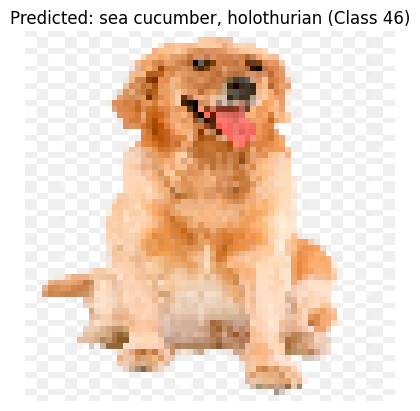

In [23]:
predict_and_visualize('/content/1.png', model, class_indices, class_labels)

Get true labels and predicted labels for the validation set

In [24]:
true_labels = []
predicted_labels = []

for images, labels in val_generator:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))
    if len(true_labels) >= val_generator.samples:
        break

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

Generate the classification report

In [25]:
from sklearn.metrics import classification_report

In [26]:
report = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()))
print(report)

              precision    recall  f1-score   support

   n01443537       0.92      0.72      0.81        50
   n01629819       0.83      0.70      0.76        50
   n01641577       0.58      0.66      0.62        50
   n01644900       0.61      0.34      0.44        50
   n01698640       0.46      0.66      0.55        50
   n01742172       0.30      0.46      0.37        50
   n01768244       0.75      0.80      0.78        50
   n01770393       0.68      0.34      0.45        50
   n01774384       0.62      0.76      0.68        50
   n01774750       0.70      0.52      0.60        50
   n01784675       0.52      0.72      0.61        50
   n01855672       0.74      0.58      0.65        50
   n01882714       0.91      0.64      0.75        50
   n01910747       0.86      0.74      0.80        50
   n01917289       0.83      0.70      0.76        50
   n01944390       0.72      0.52      0.60        50
   n01945685       0.64      0.46      0.53        50
   n01950731       0.79    

From the classification report, let’s assume identified classes with an F1-score lower than 0.50.

Assume we have true_labels and predicted_labels from previous steps:

In [27]:
report_dict = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()), output_dict=True)

Identify Poor Performing Classes:

In [28]:
def get_poor_performing_classes(report_dict, threshold=0.5):
    low_accuracy_classes = []
    for class_name, metrics in report_dict.items():
        if class_name not in ["accuracy", "macro avg", "weighted avg"]:
            if metrics["f1-score"] < threshold:
                low_accuracy_classes.append(class_name)
    return low_accuracy_classes

# Define the threshold for F1-score
f1_threshold = 0.5

# Get the list of poor performing classes
low_accuracy_classes = get_poor_performing_classes(report_dict, f1_threshold)
print(f"Poor performing classes: {low_accuracy_classes}")


Poor performing classes: ['n01644900', 'n01742172', 'n01770393', 'n02085620', 'n02099601', 'n02099712', 'n02113799', 'n02124075', 'n02231487', 'n02233338', 'n02236044', 'n02395406', 'n02403003', 'n02730930', 'n02788148', 'n02791270', 'n02795169', 'n02883205', 'n02906734', 'n02909870', 'n02948072', 'n02950826', 'n02977058', 'n02999410', 'n03160309', 'n03250847', 'n03255030', 'n03400231', 'n03404251', 'n03617480', 'n03637318', 'n03763968', 'n03770439', 'n03804744', 'n03838899', 'n03902125', 'n03970156', 'n03976657', 'n03983396', 'n04008634', 'n04023962', 'n04067472', 'n04133789', 'n04259630', 'n04265275', 'n04275548', 'n04366367', 'n04371430', 'n04376876', 'n04398044', 'n04507155', 'n04532106', 'n04560804', 'n04597913', 'n07579787', 'n07614500', 'n07711569', 'n09246464', 'n09332890']


Let's make an additional augmentation:

In [29]:
additional_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [50]:
import os
import shutil

train_dir = '/content/tiny-imagenet-200/train'

for class_name in low_accuracy_classes:
    class_dir = os.path.join(train_dir, class_name, 'images')
    if os.path.exists(class_dir):
        for file_name in os.listdir(class_dir):
            full_file_name = os.path.join(class_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, os.path.join(train_dir, class_name))
        print(f"Moved files from {class_dir} to {os.path.join(train_dir, class_name)}")
    else:
        print(f"Directory {class_dir} does not exist.")


Moved files from /content/tiny-imagenet-200/train/n01644900/images to /content/tiny-imagenet-200/train/n01644900
Moved files from /content/tiny-imagenet-200/train/n01742172/images to /content/tiny-imagenet-200/train/n01742172
Moved files from /content/tiny-imagenet-200/train/n01770393/images to /content/tiny-imagenet-200/train/n01770393
Moved files from /content/tiny-imagenet-200/train/n02085620/images to /content/tiny-imagenet-200/train/n02085620
Moved files from /content/tiny-imagenet-200/train/n02099601/images to /content/tiny-imagenet-200/train/n02099601
Moved files from /content/tiny-imagenet-200/train/n02099712/images to /content/tiny-imagenet-200/train/n02099712
Moved files from /content/tiny-imagenet-200/train/n02113799/images to /content/tiny-imagenet-200/train/n02113799
Moved files from /content/tiny-imagenet-200/train/n02124075/images to /content/tiny-imagenet-200/train/n02124075
Moved files from /content/tiny-imagenet-200/train/n02231487/images to /content/tiny-imagenet-200

Creating an additional generator for training images only with classes with low accuracy:

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from keras.utils import Sequence

# Функція для створення генератора для класів з низькою точністю
def create_class_specific_generator(generator, class_indices, classes, base_dirs):
    class_filenames = []
    class_labels = []
    for base_dir in base_dirs:
        for class_name in classes:
            class_index = class_indices[class_name]
            class_dir = os.path.join(base_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Directory {class_dir} does not exist.")
                continue
            class_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, fname)) and fname.lower().endswith(('.jpeg', '.jpg', '.png'))]
            if not class_files:
                print(f"No files found in directory {class_dir}.")
                continue
            class_filenames.extend(class_files)
            class_labels.extend([class_name] * len(class_files))
            print(f"Found {len(class_files)} files in directory {class_dir}.")

    print(f"Found {len(class_filenames)} images for augmentation.")

    if not class_filenames:
        print("No valid images found for augmentation.")
        return None

    # Додавання dummy-класів для вирівнювання кількості класів
    all_class_names = list(class_indices.keys())
    for class_name in all_class_names:
        if class_name not in classes:
            dummy_image = class_filenames[0]  # Використовуємо перше зображення як dummy
            class_filenames.append(dummy_image)
            class_labels.append(class_name)

    df = pd.DataFrame({'filename': class_filenames, 'class': class_labels})
    print(df.head())  # Перевірка DataFrame

    class_specific_generator = generator.flow_from_dataframe(
        dataframe=df,
        directory=None,  # Використання абсолютних шляхів
        x_col='filename',
        y_col='class',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    return class_specific_generator

# Переконайтеся, що train_dir і val_dir визначені правильно
train_dir = '/content/tiny-imagenet-200/train'
val_dir = '/content/tiny-imagenet-200/val'

# Створення нових екземплярів генераторів після переміщення файлів
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Створення генератора для класів з низькою точністю
additional_datagen = ImageDataGenerator(rescale=1.0/255.0)
class_indices = {class_name: idx for idx, class_name in enumerate(os.listdir(train_dir))}
additional_generator = create_class_specific_generator(additional_datagen, class_indices, low_accuracy_classes, [train_dir, val_dir])

if additional_generator is not None:
    class CombinedGenerator(Sequence):
        def __init__(self, generator1, generator2):
            self.generator1 = generator1
            self.generator2 = generator2

        def __len__(self):
            return min(len(self.generator1), len(self.generator2))

        def __getitem__(self, index):
            x1, y1 = self.generator1[index]
            x2, y2 = self.generator2[index]
            x_combined = np.concatenate((x1, x2), axis=0)
            y_combined = np.concatenate((y1, y2), axis=0)
            return x_combined, y_combined

    # Об'єднання основного і додаткового генераторів
    combined_generator = CombinedGenerator(train_generator, additional_generator)

    # Донавчання моделі з використанням об'єднаного генератора
    history = model.fit(
        combined_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr, lr_scheduler]
    )
else:
    print("Additional generator is None. Skipping training with augmented data.")


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 500 files in directory /content/tiny-imagenet-200/train/n01644900.
Found 500 files in directory /content/tiny-imagenet-200/train/n01742172.
Found 500 files in directory /content/tiny-imagenet-200/train/n01770393.
Found 500 files in directory /content/tiny-imagenet-200/train/n02085620.
Found 500 files in directory /content/tiny-imagenet-200/train/n02099601.
Found 500 files in directory /content/tiny-imagenet-200/train/n02099712.
Found 500 files in directory /content/tiny-imagenet-200/train/n02113799.
Found 500 files in directory /content/tiny-imagenet-200/train/n02124075.
Found 500 files in directory /content/tiny-imagenet-200/train/n02231487.
Found 500 files in directory /content/tiny-imagenet-200/train/n02233338.
Found 500 files in directory /content/tiny-imagenet-200/train/n02236044.
Found 500 files in directory /content/tiny-imagenet-200/train/n02395406.
Found 500 files in directory /con

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 158s 155ms/step - accuracy: 0.6927 - loss: 1.3445 - val_accuracy: 0.6620 - val_loss: 1.5343 - learning_rate: 3.6788e-05
Epoch 2/30
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 92s 90ms/step - accuracy: 0.7823 - loss: 0.9539 - val_accuracy: 0.6857 - val_loss: 1.4401 - learning_rate: 3.6788e-05
Epoch 3/30
 889/1019 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.8359 - loss: 0.7465

Evaluate the model

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()